<a href="https://colab.research.google.com/github/oleksii-shcherbak/GoIT-num-prog-py-hw/blob/main/hw_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

### Step 2

In [2]:
def generate_synthetic_data():
    """Generate synthetic 1D data from mixture of three Gaussians."""
    n_samples = 100

    # Parameters for three Gaussian components
    mu1, sigma1 = -5, 1.5
    mu2, sigma2 = 5, 2.0
    mu3, sigma3 = 0, 3.0

    # Generate samples from each component
    x1 = np.random.normal(mu1, np.sqrt(sigma1), n_samples)
    x2 = np.random.normal(mu2, np.sqrt(sigma2), n_samples)
    x3 = np.random.normal(mu3, np.sqrt(sigma3), n_samples)

    # Combine all samples
    X = np.concatenate([x1, x2, x3])

    return X, (mu1, mu2, mu3), (sigma1, sigma2, sigma3)

# Generate data
X_1d, true_means, true_variances = generate_synthetic_data()
print(f"Generated {len(X_1d)} data points")
print(f"True means: {true_means}")
print(f"True variances: {true_variances}")

Generated 300 data points
True means: (-5, 5, 0)
True variances: (1.5, 2.0, 3.0)


### Step 3

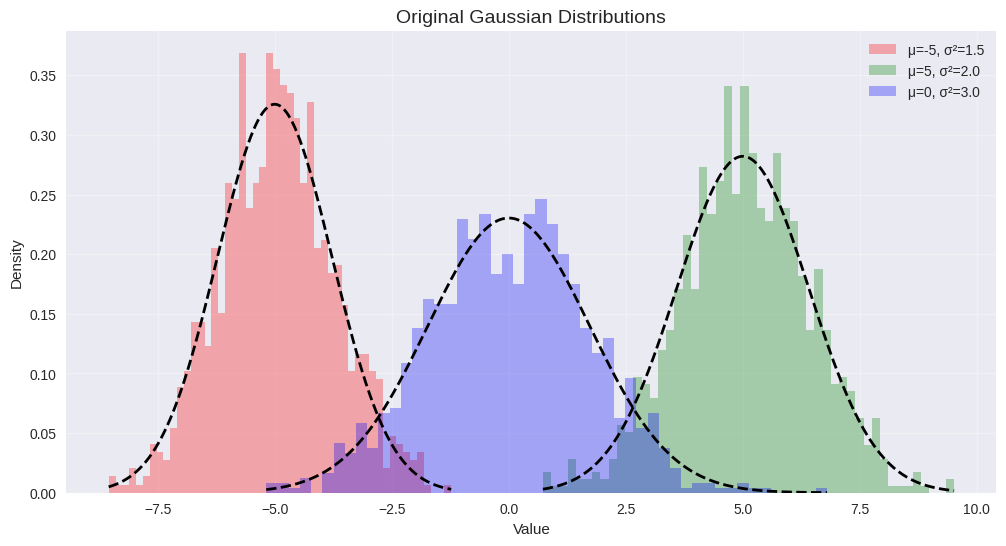

In [3]:
def plot_gaussian_pdf(mu, sigma, label, alpha=0.5, linestyle='k--',
                     density=True, color='blue', n_samples=1000):
    """Plot histogram and PDF of a Gaussian distribution."""
    X_sample = np.random.normal(mu, sigma, n_samples)
    plt.hist(X_sample, bins=50, density=density, alpha=alpha,
             label=label, color=color)

    # Plot the theoretical PDF
    x_range = np.linspace(X_sample.min(), X_sample.max(), 1000)
    y_pdf = norm.pdf(x_range, mu, sigma)
    plt.plot(x_range, y_pdf, linestyle, linewidth=2)

def visualize_original_distributions():
    """Visualize the original three Gaussian distributions."""
    plt.figure(figsize=(12, 6))

    colors = ['red', 'green', 'blue']
    for i, (mu, sigma, color) in enumerate(zip(true_means, true_variances, colors)):
        plot_gaussian_pdf(mu, np.sqrt(sigma),
                         f'μ={mu}, σ²={sigma}',
                         color=color, alpha=0.3)

    plt.title('Original Gaussian Distributions', fontsize=14)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_original_distributions()

### Step 4

In [4]:
class GMMFromScratch:
    """Gaussian Mixture Model implemented from scratch using EM algorithm."""

    def __init__(self, n_components=3, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_parameters(self, X):
        """Initialize parameters randomly."""
        n_samples = len(X)

        # Initialize mixing coefficients (weights)
        self.pi = np.ones(self.n_components) / self.n_components

        # Initialize means randomly from data
        self.means = np.random.choice(X, self.n_components)

        # Initialize variances randomly
        self.variances = np.random.random(self.n_components)

        return self.means.copy(), self.variances.copy(), self.pi.copy()

    def _expectation_step(self, X):
        """E-step: Calculate responsibilities (posterior probabilities)."""
        n_samples = len(X)
        responsibilities = np.zeros((self.n_components, n_samples))

        # Calculate likelihood for each component
        for k in range(self.n_components):
            responsibilities[k, :] = norm.pdf(X, self.means[k],
                                            np.sqrt(self.variances[k]))

        # Multiply by mixing coefficients
        for k in range(self.n_components):
            responsibilities[k, :] *= self.pi[k]

        # Normalize to get responsibilities
        total_responsibility = np.sum(responsibilities, axis=0)
        responsibilities /= total_responsibility[np.newaxis, :]

        return responsibilities

    def _maximization_step(self, X, responsibilities):
        """M-step: Update parameters based on responsibilities."""
        n_samples = len(X)

        # Update mixing coefficients
        for k in range(self.n_components):
            self.pi[k] = np.mean(responsibilities[k, :])

        # Update means and variances
        for k in range(self.n_components):
            # Weighted mean
            self.means[k] = np.sum(responsibilities[k, :] * X) / np.sum(responsibilities[k, :])

            # Weighted variance
            self.variances[k] = np.sum(responsibilities[k, :] * (X - self.means[k])**2) / np.sum(responsibilities[k, :])

    def _calculate_log_likelihood(self, X):
        """Calculate log-likelihood of the data."""
        n_samples = len(X)
        log_likelihood = 0

        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                sample_likelihood += self.pi[k] * norm.pdf(X[i], self.means[k],
                                                         np.sqrt(self.variances[k]))
            log_likelihood += np.log(sample_likelihood)

        return log_likelihood

    def fit(self, X, verbose=False):
        """Fit the Gaussian Mixture Model using EM algorithm."""
        # Initialize parameters
        initial_means, initial_vars, initial_pi = self._initialize_parameters(X)

        if verbose:
            print("Initial parameters:")
            print(f"Means: {initial_means}")
            print(f"Variances: {initial_vars}")
            print(f"Mixing coefficients: {initial_pi}")

        log_likelihoods = []

        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._expectation_step(X)

            # M-step
            old_means = self.means.copy()
            self._maximization_step(X, responsibilities)

            # Calculate log-likelihood
            log_likelihood = self._calculate_log_likelihood(X)
            log_likelihoods.append(log_likelihood)

            # Check for convergence
            if iteration > 0:
                if abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tol:
                    if verbose:
                        print(f"Converged after {iteration + 1} iterations")
                    break

            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.4f}")

        self.log_likelihoods_ = log_likelihoods
        return self

    def predict_proba(self, X):
        """Predict class probabilities for X."""
        return self._expectation_step(X).T

    def predict(self, X):
        """Predict class labels for X."""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# Fit our custom GMM
gmm_custom = GMMFromScratch(n_components=3, max_iter=200)
gmm_custom.fit(X_1d, verbose=True)

print(f"\nFinal parameters:")
print(f"Means: {gmm_custom.means}")
print(f"Variances: {gmm_custom.variances}")
print(f"Mixing coefficients: {gmm_custom.pi}")

Initial parameters:
Means: [3.62159196 2.80703075 4.89700436]
Variances: [0.12832586 0.57849251 0.69342213]
Mixing coefficients: [0.33333333 0.33333333 0.33333333]
Iteration 10: Log-likelihood = -837.6074
Iteration 20: Log-likelihood = -837.4777
Iteration 30: Log-likelihood = -837.3452
Iteration 40: Log-likelihood = -837.0393
Iteration 50: Log-likelihood = -835.7157
Iteration 60: Log-likelihood = -835.4091
Iteration 70: Log-likelihood = -835.3681
Iteration 80: Log-likelihood = -835.3541
Iteration 90: Log-likelihood = -835.3480
Iteration 100: Log-likelihood = -835.3450
Iteration 110: Log-likelihood = -835.3434
Iteration 120: Log-likelihood = -835.3425
Iteration 130: Log-likelihood = -835.3419
Iteration 140: Log-likelihood = -835.3415
Iteration 150: Log-likelihood = -835.3413
Iteration 160: Log-likelihood = -835.3412
Iteration 170: Log-likelihood = -835.3411
Iteration 180: Log-likelihood = -835.3410
Iteration 190: Log-likelihood = -835.3409
Iteration 200: Log-likelihood = -835.3409

Fina

### Step 5

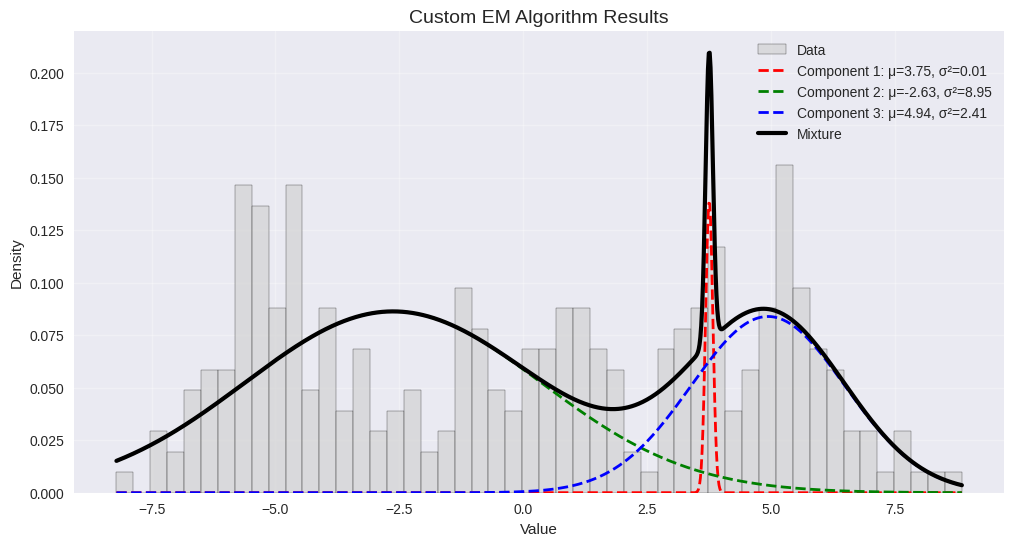

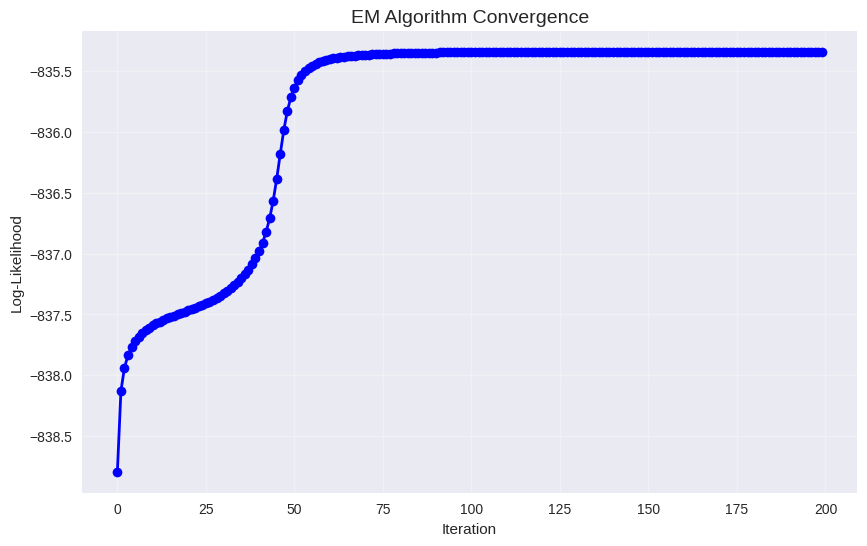

In [5]:
def plot_gmm_results(X, gmm_model, title="GMM Results"):
    """Plot the fitted GMM components."""
    plt.figure(figsize=(12, 6))

    # Plot histogram of data
    plt.hist(X, bins=50, density=True, alpha=0.7, color='lightgray',
             label='Data', edgecolor='black')

    # Plot fitted components
    x_range = np.linspace(X.min(), X.max(), 1000)
    colors = ['red', 'green', 'blue']

    total_pdf = np.zeros_like(x_range)

    for k in range(gmm_model.n_components):
        # Individual component
        component_pdf = gmm_model.pi[k] * norm.pdf(x_range,
                                                  gmm_model.means[k],
                                                  np.sqrt(gmm_model.variances[k]))
        plt.plot(x_range, component_pdf, '--', color=colors[k], linewidth=2,
                label=f'Component {k+1}: μ={gmm_model.means[k]:.2f}, σ²={gmm_model.variances[k]:.2f}')
        total_pdf += component_pdf

    # Total mixture
    plt.plot(x_range, total_pdf, 'k-', linewidth=3, label='Mixture')

    plt.title(title, fontsize=14)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot results from custom implementation
plot_gmm_results(X_1d, gmm_custom, "Custom EM Algorithm Results")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(gmm_custom.log_likelihoods_, 'b-', linewidth=2, marker='o')
plt.title('EM Algorithm Convergence', fontsize=14)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True, alpha=0.3)
plt.show()

### Step 6

Scikit-learn GMM Results:
Means: [ 4.87985418 -4.99693481  0.06673659]
Variances: [2.15439847 1.49841587 2.10633048]
Mixing coefficients: [0.36106777 0.355278   0.28365422]


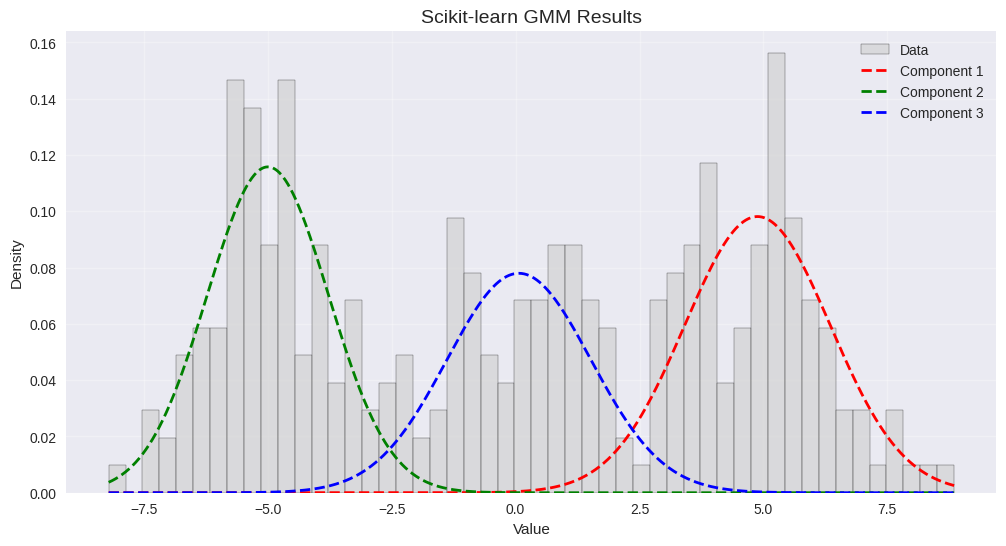

In [6]:
# Fit scikit-learn GMM
X_reshaped = X_1d.reshape(-1, 1)
gmm_sklearn = GaussianMixture(n_components=3, random_state=42)
gmm_sklearn.fit(X_reshaped)

print("Scikit-learn GMM Results:")
print(f"Means: {gmm_sklearn.means_.flatten()}")
print(f"Variances: {gmm_sklearn.covariances_.flatten()}")
print(f"Mixing coefficients: {gmm_sklearn.weights_}")

# Visualize sklearn results
plt.figure(figsize=(12, 6))
plt.hist(X_1d, bins=50, density=True, alpha=0.7, color='lightgray',
         label='Data', edgecolor='black')

x_range = np.linspace(X_1d.min(), X_1d.max(), 1000)
colors = ['red', 'green', 'blue']

for k in range(3):
    component_pdf = (gmm_sklearn.weights_[k] *
                    norm.pdf(x_range, gmm_sklearn.means_[k, 0],
                             np.sqrt(gmm_sklearn.covariances_[k, 0, 0])))
    plt.plot(x_range, component_pdf, '--', color=colors[k], linewidth=2,
            label=f'Component {k+1}')

plt.title('Scikit-learn GMM Results', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 7

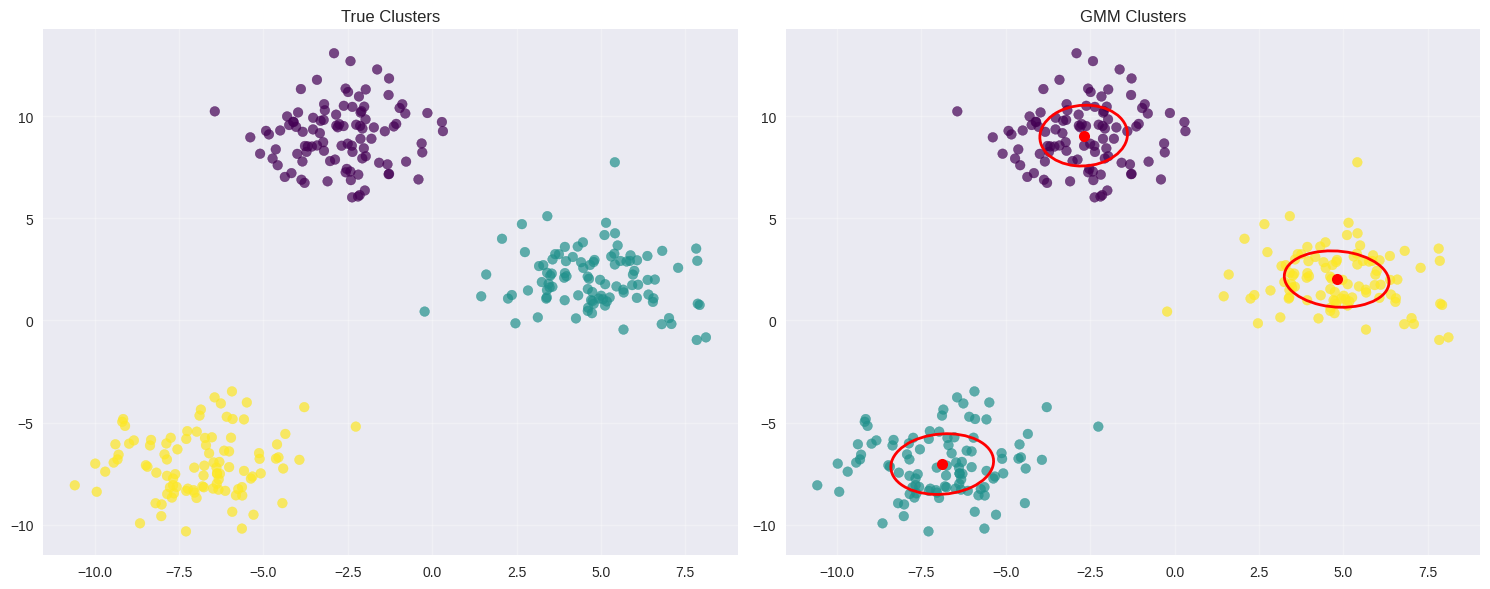

In [7]:
def create_2d_gmm_example():
    """Create and visualize 2D Gaussian Mixture Model."""
    # Generate 2D data
    X_2d, y_true = make_blobs(n_samples=300, centers=3, n_features=2,
                              random_state=42, cluster_std=1.5)

    # Fit GMM
    gmm_2d = GaussianMixture(n_components=3, random_state=42)
    gmm_2d.fit(X_2d)
    y_pred = gmm_2d.predict(X_2d)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot original clusters
    axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    axes[0].set_title('True Clusters')
    axes[0].grid(True, alpha=0.3)

    # Plot GMM results
    axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, cmap='viridis', alpha=0.7)

    # Plot GMM components
    for i in range(3):
        mean = gmm_2d.means_[i]
        cov = gmm_2d.covariances_[i]

        # Plot confidence ellipse
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
        width, height = 2 * np.sqrt(eigenvals)

        from matplotlib.patches import Ellipse
        ellipse = Ellipse(mean, width, height, angle=angle,
                         fill=False, color='red', linewidth=2)
        axes[1].add_patch(ellipse)
        axes[1].plot(mean[0], mean[1], 'ro', markersize=8)

    axes[1].set_title('GMM Clusters')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return X_2d, gmm_2d

X_2d, gmm_2d = create_2d_gmm_example()

### Step 8

Classification Results:
Standard LDA Accuracy: 1.000
Mixture Discriminant Analysis Accuracy: 0.978


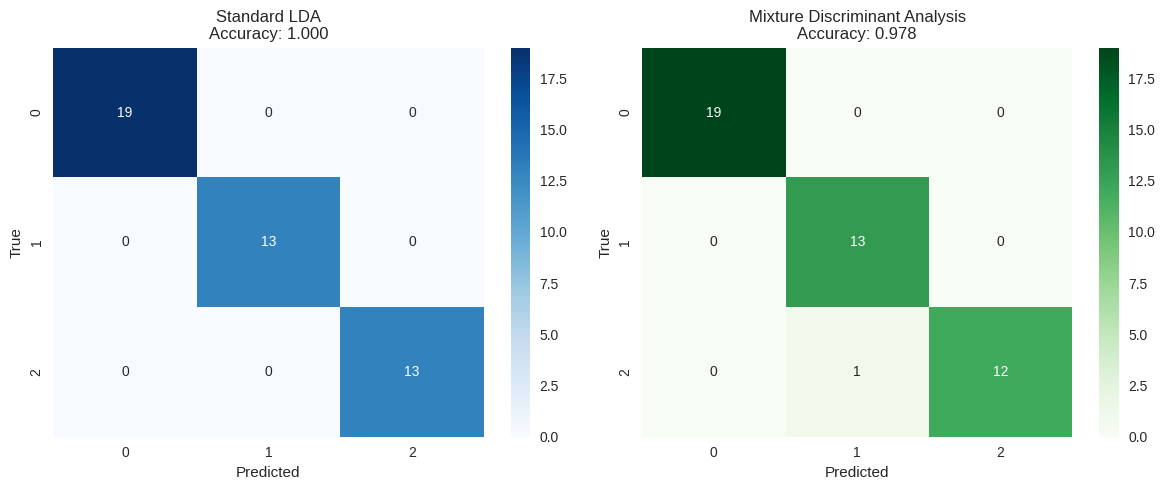

In [8]:
def demonstrate_mixture_discriminant_analysis():
    """Demonstrate Mixture Discriminant Analysis using Iris dataset."""
    # Load Iris dataset
    iris = load_iris()
    X, y = iris.data, iris.target

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    # Method 1: Standard LDA
    lda_standard = LinearDiscriminantAnalysis()
    lda_standard.fit(X_train, y_train)
    y_pred_lda = lda_standard.predict(X_test)

    # Method 2: GMM for each class + LDA
    gmm_models = []
    for class_label in np.unique(y_train):
        X_class = X_train[y_train == class_label]
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(X_class)
        gmm_models.append(gmm)

    # Extract features from GMM (log-likelihood for each component)
    def extract_gmm_features(X, gmm_models):
        features = []
        for gmm in gmm_models:
            log_likelihood = gmm.score_samples(X)
            features.append(log_likelihood)
        return np.column_stack(features)

    # Transform training and test data
    X_train_gmm = extract_gmm_features(X_train, gmm_models)
    X_test_gmm = extract_gmm_features(X_test, gmm_models)

    # Train LDA on GMM features
    lda_gmm = LinearDiscriminantAnalysis()
    lda_gmm.fit(X_train_gmm, y_train)
    y_pred_mda = lda_gmm.predict(X_test_gmm)

    # Compare results
    acc_lda = accuracy_score(y_test, y_pred_lda)
    acc_mda = accuracy_score(y_test, y_pred_mda)

    print("Classification Results:")
    print(f"Standard LDA Accuracy: {acc_lda:.3f}")
    print(f"Mixture Discriminant Analysis Accuracy: {acc_mda:.3f}")

    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # LDA confusion matrix
    cm_lda = confusion_matrix(y_test, y_pred_lda)
    sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Standard LDA\nAccuracy: {acc_lda:.3f}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # MDA confusion matrix
    cm_mda = confusion_matrix(y_test, y_pred_mda)
    sns.heatmap(cm_mda, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'Mixture Discriminant Analysis\nAccuracy: {acc_mda:.3f}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    return gmm_models, lda_standard, lda_gmm

gmm_models, lda_standard, lda_gmm = demonstrate_mixture_discriminant_analysis()

### Step 9

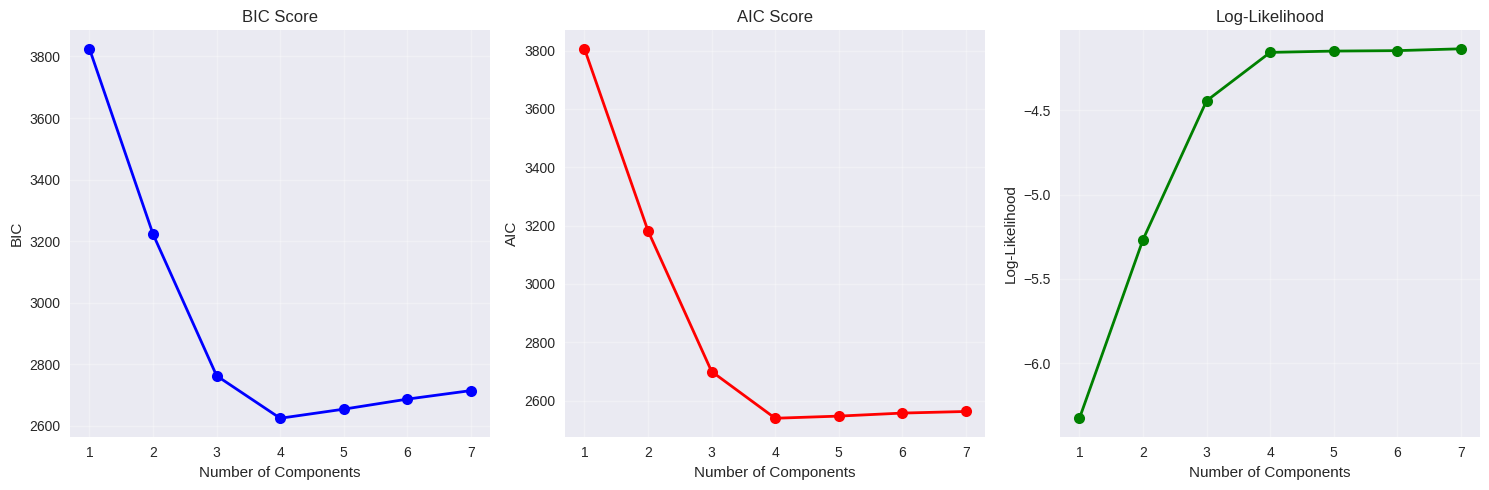

Optimal number of components (BIC): 4
Optimal number of components (AIC): 4


In [9]:
def model_selection_demo():
    """Demonstrate model selection for GMM using different criteria."""
    X_2d_simple, _ = make_blobs(n_samples=300, centers=4, n_features=2,
                               random_state=42, cluster_std=1.0)

    # Test different numbers of components
    n_components_range = range(1, 8)
    bic_scores = []
    aic_scores = []
    log_likelihoods = []

    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X_2d_simple)

        bic_scores.append(gmm.bic(X_2d_simple))
        aic_scores.append(gmm.aic(X_2d_simple))
        log_likelihoods.append(gmm.score(X_2d_simple))

    # Plot model selection criteria
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # BIC scores
    axes[0].plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8)
    axes[0].set_title('BIC Score')
    axes[0].set_xlabel('Number of Components')
    axes[0].set_ylabel('BIC')
    axes[0].grid(True, alpha=0.3)

    # AIC scores
    axes[1].plot(n_components_range, aic_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_title('AIC Score')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('AIC')
    axes[1].grid(True, alpha=0.3)

    # Log-likelihood
    axes[2].plot(n_components_range, log_likelihoods, 'go-', linewidth=2, markersize=8)
    axes[2].set_title('Log-Likelihood')
    axes[2].set_xlabel('Number of Components')
    axes[2].set_ylabel('Log-Likelihood')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find optimal number of components
    optimal_bic = n_components_range[np.argmin(bic_scores)]
    optimal_aic = n_components_range[np.argmin(aic_scores)]

    print(f"Optimal number of components (BIC): {optimal_bic}")
    print(f"Optimal number of components (AIC): {optimal_aic}")

    return optimal_bic, optimal_aic

optimal_bic, optimal_aic = model_selection_demo()

### Step 10

In [10]:
def print_summary():
    """Print comprehensive summary of key concepts."""
    print("="*60)
    print("GAUSSIAN MIXTURE MODELS AND EM ALGORITHM - SUMMARY")
    print("="*60)

    print("\n1. KEY CONCEPTS:")
    print("   • Soft clustering: Objects can belong to multiple clusters with probabilities")
    print("   • Mixture models: Combine multiple probability distributions")
    print("   • EM Algorithm: Iterative optimization (Expectation + Maximization)")
    print("   • Likelihood: Probability of observing data given model parameters")

    print("\n2. EM ALGORITHM STEPS:")
    print("   E-step: Calculate responsibilities (posterior probabilities)")
    print("   M-step: Update parameters (means, variances, mixing coefficients)")
    print("   Iterate until convergence")

    print("\n3. ADVANTAGES:")
    print("   • Flexible modeling of complex data distributions")
    print("   • Probabilistic cluster assignments")
    print("   • Can model overlapping clusters")
    print("   • Provides uncertainty estimates")

    print("\n4. LIMITATIONS:")
    print("   • Sensitive to initialization")
    print("   • May converge to local optima")
    print("   • Need to specify number of components")
    print("   • Assumes Gaussian distributions")

    print("\n5. APPLICATIONS:")
    print("   • Customer segmentation")
    print("   • Image segmentation")
    print("   • Speech recognition")
    print("   • Anomaly detection")
    print("   • Dimensionality reduction")

    print("\n6. MODEL SELECTION:")
    print("   • Use BIC/AIC for optimal number of components")
    print("   • Cross-validation for parameter tuning")
    print("   • Consider domain knowledge")

    print("="*60)

print_summary()

GAUSSIAN MIXTURE MODELS AND EM ALGORITHM - SUMMARY

1. KEY CONCEPTS:
   • Soft clustering: Objects can belong to multiple clusters with probabilities
   • Mixture models: Combine multiple probability distributions
   • EM Algorithm: Iterative optimization (Expectation + Maximization)
   • Likelihood: Probability of observing data given model parameters

2. EM ALGORITHM STEPS:
   E-step: Calculate responsibilities (posterior probabilities)
   M-step: Update parameters (means, variances, mixing coefficients)
   Iterate until convergence

3. ADVANTAGES:
   • Flexible modeling of complex data distributions
   • Probabilistic cluster assignments
   • Can model overlapping clusters
   • Provides uncertainty estimates

4. LIMITATIONS:
   • Sensitive to initialization
   • May converge to local optima
   • Need to specify number of components
   • Assumes Gaussian distributions

5. APPLICATIONS:
   • Customer segmentation
   • Image segmentation
   • Speech recognition
   • Anomaly detection
 